In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Imports

In [2]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D, Dropout, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import nltk
import re
from nltk.corpus import stopwords
from textblob import Word, TextBlob

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

### Load Dataset

In [3]:
train_df = pd.read_csv('/content/train_data.csv')

### Data Preprocessing

In [4]:
train_df.drop(columns=['id','keyword','location'], axis=1, inplace=True)
print(train_df.shape)

(7613, 2)


In [5]:
train_df.head()

,text,target
0,Our Deeds are the Reason of this # earthquake...,1
1,Forest fire near La Ronge Sask . Canada,1
2,All residents asked to ' shelter in place ' ...,1
3,"13,000 people receive # wildfires evacuation ...",1
4,Just got sent this photo from Ruby # Alaska a...,1


In [6]:
train_df["text"]=train_df["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))
train_df["text"]=train_df["text"].str.replace('[^\w\s]', '').replace('\d', '')

sw=stopwords.words('english')
train_df["text"]=train_df["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
train_df["text"]=train_df["text"].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))

train_df.head()

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,13000 people receive wildfire evacuation order...,1
4,got sent photo ruby alaska smoke wildfire pour...,1


# Keras Embeddings

### Splitting Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text'],train_df['target'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6090,) (6090,) (1523,) (1523,)


### Tokenizing

In [22]:
vocab_size = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

tokenizer.fit_on_texts(X_train)

In [23]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
max_length = 120
trunc_type = 'post'
pad_type = 'post'

X_train_padded = pad_sequences(X_train, maxlen=max_length, truncating=trunc_type, padding=pad_type)
X_test_padded = pad_sequences(X_test, maxlen=max_length, truncating=trunc_type, padding=pad_type)

In [25]:
print(X_train_padded.shape, X_test_padded.shape)

(6090, 120) (1523, 120)


In [26]:
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))
y_train = np.array(y_train)
y_test = np.array(y_test)
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Model Creation

In [27]:
embedding_dim = 300

In [28]:
model = Sequential()
# define CNN model
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# define LSTM model
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(GRU(32, return_sequences=True))
##model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
##model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

### Model Compilation

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(
    loss = "binary_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"]
)

In [30]:
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

In [31]:
ep = EarlyStopping(
    monitor='val_accuracy', 
    patience=7,
)

### Model Training

In [32]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
38/39 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5709
Epoch 00001: val_accuracy improved from -inf to 0.55993, saving model to my_checkpoint.ckpt
39/39 [==============================] - 9s 116ms/step - loss: 0.6838 - accuracy: 0.5712 - val_loss: 0.6842 - val_accuracy: 0.5599
Epoch 2/25
38/39 [============================>.] - ETA: 0s - loss: 0.6784 - accuracy: 0.5722
Epoch 00002: val_accuracy did not improve from 0.55993
39/39 [==============================] - 2s 61ms/step - loss: 0.6784 - accuracy: 0.5720 - val_loss: 0.6780 - val_accuracy: 0.5599
Epoch 3/25
39/39 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.5846
Epoch 00003: val_accuracy improved from 0.55993 to 0.66667, saving model to my_checkpoint.ckpt
39/39 [==============================] - 3s 77ms/step - loss: 0.6650 - accuracy: 0.5846 - val_loss: 0.6569 - val_accuracy: 0.6667
Epoch 4/25
38/39 [============================>.] - ETA: 0s - loss: 0.6234 - accuracy

### Graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


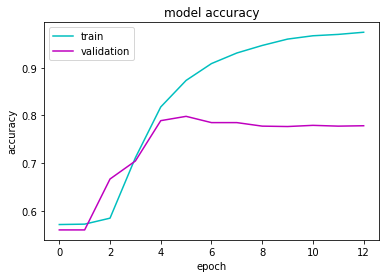

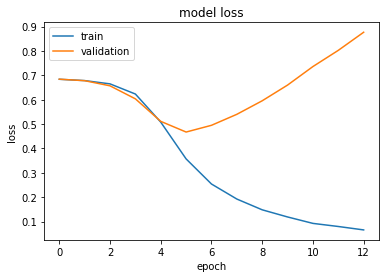

In [33]:
print(history.history.keys())
plt.axes().set(facecolor ="white")
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy').set_color('black')
plt.ylabel('accuracy').set_color('black')
plt.xlabel('epoch').set_color('black')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.axes().set(facecolor ="white")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model loss').set_color('black')
plt.ylabel('loss').set_color('black')
plt.xlabel('epoch').set_color('black')
plt.show()

### Model Evaluation

In [34]:
model.evaluate(X_test_padded, y_test)

48/48 [==============================] - 1s 11ms/step - loss: 0.8394 - accuracy: 0.7702


[0.8393506407737732, 0.770190417766571]

### Predicting Test Data

In [35]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")
#predict_x=model.predict(X_test_padded) 
#predictions=np.argmax(predict_x,axis=1)

### Accuracy

In [36]:
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.7701904136572554


### Confusion Matrix

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.77497   0.84422   0.80811       873
           1    0.76224   0.67077   0.71358       650

    accuracy                        0.77019      1523
   macro avg    0.76861   0.75749   0.76085      1523
weighted avg    0.76954   0.77019   0.76777      1523



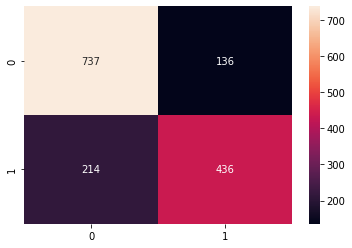

In [37]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

### Predicting new tweets

In [38]:
def preprocess_tweet(new_tweet):    
    new_tweet = new_tweet.lower()
    new_tweet = re.sub('[^\w\s]', '', new_tweet)
    new_tweet = re.sub('\d', '', new_tweet)

    new_tweet = " ".join(x for x in new_tweet.split() if x not in sw)
    new_tweet = " ".join([Word(word).lemmatize() for word in new_tweet.split()])
    print("On preprocessing:", new_tweet)
    
    tokenizer.fit_on_texts(new_tweet)

    new_tweet = tokenizer.texts_to_sequences([new_tweet])

    new_tweet =  pad_sequences(new_tweet, maxlen=max_length, truncating=trunc_type, padding=pad_type)

    return new_tweet

def predict_newTweet(tweet):
    print("Input Tweet: ", tweet)
    emb_tweet = preprocess_tweet(tweet)
    result = (model.predict(emb_tweet) > 0.5).astype("int32")
#     print(result)
    print("Output: " + "Real News" if result[0][0] == 1 else "Fake News")


In [39]:
new_tweet = "Fires start in apartment buildings in Chicago; cyclone damaged houses please help us; its an earthquake; injuring 20 civilians #CNN"
predict_newTweet(new_tweet)

Input Tweet:  Fires start in apartment buildings in Chicago; cyclone damaged houses please help us; its an earthquake; injuring 20 civilians #CNN
On preprocessing: fire start apartment building chicago cyclone damaged house please help u earthquake injuring civilian cnn
Output: Real News


In [40]:
new_tweet = "Car pooling must be incorporated to increase pollution"
predict_newTweet(new_tweet)

Input Tweet:  Car pooling must be incorporated to increase pollution
On preprocessing: car pooling must incorporated increase pollution
Fake News


# Word2Vec Exploration

In [7]:
import gensim
X = [d.split() for d in train_df['text'].tolist()]
DIM = 300
w2v_model = gensim.models.Word2Vec(sentences = X, size = DIM, window = 10, min_count = 1)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [9]:
X = tokenizer.texts_to_sequences(X)

In [10]:
X = pad_sequences(X, maxlen = 120)
vocab_size = len(tokenizer.word_index) + 1

In [11]:
vocab = tokenizer.word_index
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))

    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]

    return weight_matrix

In [12]:
embedding_vectors = get_weight_matrix(w2v_model)
embedding_vectors.shape
max_length = 120

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D
model = Sequential()
model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = max_length, trainable = True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(GRU(32, return_sequences=True))
#model.add(Bidirectional(GRU(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          4661100   
                                                                 
 conv1d (Conv1D)             (None, 113, 32)           76832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 56, 32)           0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 56, 32)            6336      
                                                                 
 dropout (Dropout)           (None, 56, 32)            0         
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                        

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,train_df['target'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6090, 120) (6090,) (1523, 120) (1523,)


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7,)

In [17]:
epochs=25
history = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
39/39 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5659
Epoch 00001: val_accuracy improved from -inf to 0.55993, saving model to my_checkpoint.ckpt
39/39 [==============================] - 18s 83ms/step - loss: 0.6906 - accuracy: 0.5659 - val_loss: 0.6859 - val_accuracy: 0.5599
Epoch 2/25
37/39 [===========================>..] - ETA: 0s - loss: 0.6816 - accuracy: 0.5720
Epoch 00002: val_accuracy did not improve from 0.55993
39/39 [==============================] - 1s 33ms/step - loss: 0.6814 - accuracy: 0.5727 - val_loss: 0.6815 - val_accuracy: 0.5599
Epoch 3/25
39/39 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.5854
Epoch 00003: val_accuracy improved from 0.55993 to 0.58456, saving model to my_checkpoint.ckpt
39/39 [==============================] - 2s 42ms/step - loss: 0.6732 - accuracy: 0.5854 - val_loss: 0.6707 - val_accuracy: 0.5846
Epoch 4/25
39/39 [==============================] - ETA: 0s - loss: 0.6601 - accuracy

In [18]:
model.evaluate(X_test, y_test)

48/48 [==============================] - 1s 11ms/step - loss: 0.7678 - accuracy: 0.7676


[0.767827570438385, 0.7675639986991882]

In [19]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.767564018384767


Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.78054   0.82703   0.80311       873
           1    0.74749   0.68769   0.71635       650

    accuracy                        0.76756      1523
   macro avg    0.76402   0.75736   0.75973      1523
weighted avg    0.76644   0.76756   0.76608      1523



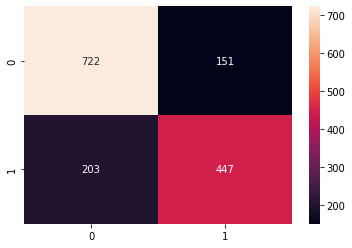

In [20]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

# Glove Exploration

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text'],train_df['target'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return word_to_vec_map

In [ ]:
word_to_vec_map = read_glove_vector('../input/glove6b100dtxt/glove.6B.100d.txt')
maxLen = 120

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

#embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)


In [ ]:
maxLen = 120
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=maxLen, padding='post')
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=maxLen, padding='post')

In [ ]:
model = Sequential()
# define CNN model
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Embedding(input_dim=6000, output_dim=768, input_length=120, weights = [emb_matrix], trainable=True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# define LSTM model
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(GRU(32, return_sequences=True))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7)

In [ ]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

2021-12-26 15:13:37.713096: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2021-12-26 15:13:42.314319: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


39/39 [==============================] - 11s 43ms/step - loss: 0.6891 - accuracy: 0.5608 - val_loss: 0.6829 - val_accuracy: 0.5599

Epoch 00001: val_accuracy improved from -inf to 0.55993, saving model to my_checkpoint.ckpt
Epoch 2/25
39/39 [==============================] - 1s 21ms/step - loss: 0.6817 - accuracy: 0.5686 - val_loss: 0.6747 - val_accuracy: 0.5665

Epoch 00002: val_accuracy improved from 0.55993 to 0.56650, saving model to my_checkpoint.ckpt
Epoch 3/25
39/39 [==============================] - 1s 21ms/step - loss: 0.6725 - accuracy: 0.5862 - val_loss: 0.6634 - val_accuracy: 0.6002

Epoch 00003: val_accuracy improved from 0.56650 to 0.60016, saving model to my_checkpoint.ckpt
Epoch 4/25
39/39 [==============================] - 1s 21ms/step - loss: 0.6650 - accuracy: 0.5922 - val_loss: 0.6605 - val_accuracy: 0.5920

Epoch 00004: val_accuracy did not improve from 0.60016
Epoch 5/25
39/39 [==============================] - 1s 21ms/step - loss: 0.6621 - accuracy: 0.6012 - val_

In [ ]:
model.evaluate(X_test_padded, y_test)

48/48 [==============================] - 0s 6ms/step - loss: 0.6628 - accuracy: 0.7859


[0.6627748012542725, 0.7859488129615784]

In [ ]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.77268   0.88774   0.82623       873
           1    0.81154   0.64923   0.72137       650

    accuracy                        0.78595      1523
   macro avg    0.79211   0.76849   0.77380      1523
weighted avg    0.78927   0.78595   0.78147      1523



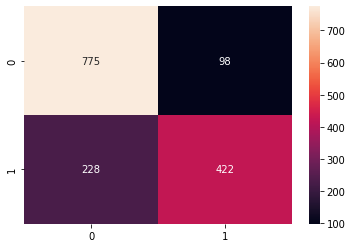

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

# BERT Exploration

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text'],train_df['target'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6090,) (6090,) (1523,) (1523,)


In [ ]:
bert_abstract = ""
for sent in X_train:
    bert_abstract += sent +" "

In [ ]:
len(bert_abstract)

394864

In [ ]:
!pip install transformers -U

     |████████████████████████████████| 3.4 MB 637 kB/s            
     |████████████████████████████████| 15.7 MB 33.0 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Attempting uninstall: transformers
    Found existing installation: transformers 4.12.5
    Uninstalling transformers-4.12.5:
      Successfully uninstalled transformers-4.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
cudf 21.10.1 requires cupy-cuda110, which is not installed.
beatrix-jupyterlab 3.1.4 requires google-cloud-bigquery-storage,

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = tf.constant(tokenizer.encode(bert_abstract))[None, :6000]  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2021-12-26 15:12:48.209434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 15:12:48.210918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 15:12:48.211992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 15:12:48.213409: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
import numpy as np
emb_matrix = np.array(last_hidden_states)
emb_matrix = emb_matrix[0]

In [ ]:
emb_matrix.shape

(6000, 768)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index

In [ ]:
maxLen = 120
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=maxLen, padding='post')
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=maxLen, padding='post')

In [ ]:
model = Sequential()
# define CNN model
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Embedding(input_dim=6000, output_dim=768, input_length=120, weights = [emb_matrix], trainable=True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(GRU(32, return_sequences=True))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7)

In [ ]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
39/39 [==============================] - 5s 39ms/step - loss: 0.6764 - accuracy: 0.5807 - val_loss: 0.6667 - val_accuracy: 0.5944

Epoch 00001: val_accuracy improved from -inf to 0.59442, saving model to my_checkpoint.ckpt
Epoch 2/25
39/39 [==============================] - 1s 21ms/step - loss: 0.6654 - accuracy: 0.5944 - val_loss: 0.6592 - val_accuracy: 0.5944

Epoch 00002: val_accuracy did not improve from 0.59442
Epoch 3/25
39/39 [==============================] - 1s 21ms/step - loss: 0.6611 - accuracy: 0.6041 - val_loss: 0.6547 - val_accuracy: 0.6125

Epoch 00003: val_accuracy improved from 0.59442 to 0.61248, saving model to my_checkpoint.ckpt
Epoch 4/25
39/39 [==============================] - 1s 20ms/step - loss: 0.6507 - accuracy: 0.6205 - val_loss: 0.6491 - val_accuracy: 0.6174

Epoch 00004: val_accuracy improved from 0.61248 to 0.61741, saving model to my_checkpoint.ckpt
Epoch 5/25
39/39 [==============================] - 1s 20ms/step - loss: 0.6533 - accuracy: 0.6

In [ ]:
model.evaluate(X_test_padded, y_test)

48/48 [==============================] - 0s 9ms/step - loss: 0.5962 - accuracy: 0.7971


[0.5961766242980957, 0.7971109747886658]

In [ ]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.77647   0.90722   0.83677       873
           1    0.83897   0.64923   0.73200       650

    accuracy                        0.79711      1523
   macro avg    0.80772   0.77822   0.78439      1523
weighted avg    0.80314   0.79711   0.79206      1523



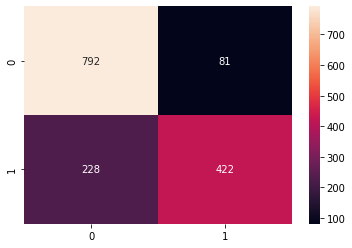

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))